In [1]:
import pandas as pd
import tensorflow as tf
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)

from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import numpy as np
from statistics import mean

import IPython
import IPython.display

In [2]:
df = pd.read_csv ('Data/weekly_features.csv')
df = df.drop (columns = ['Unnamed: 0','USD_PHP Historical Data.csv'])
dates = df.year*100+df.week
df['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
mask = (df['Date'] >'1990-09-30') & (df['Date'] <= '2021-09-30')
df= df.loc[mask]
df = df.fillna(method='ffill')

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.to_datetime().timetuple())

# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
# difference dataset
diff_df=df.drop(columns=['Date', 'year', 'week'])
diff_df = diff_df.diff()
diff_df = diff_df.iloc[1:]
#diff_df['year']=df.year[1:]
#diff_df['week']=df.year[1:]
diff_df['Date']=df.Date[1:]
diff_df['Date'] = pd.to_datetime(diff_df['Date'])
# convert date to timestamp
diff_df['Date'] = diff_df['Date'].map(pd.Timestamp.timestamp)

#split the data into training and testing dataset
column_indices = {name: i for i, name in enumerate(diff_df.columns)}

n = len(diff_df)
train_df = diff_df[0:int(n*0.7)]
test_df = diff_df[int(n*0.7):]

num_features = diff_df.shape[1]

#Normalize the data
from sklearn.preprocessing import MinMaxScaler
#col_list = [i for i in diff_df.columns if i != 'Date']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

#### raw values generate from df

In [3]:
raw_values = df.drop(columns=['year','week'])
raw_values['Date'] = pd.to_datetime(raw_values['Date'])
# convert date to timestamp
raw_values['Date'] = raw_values['Date'].map(pd.Timestamp.timestamp)

### sliding window

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

### compile and fit function

In [5]:
# Function of training models
MAX_EPOCHS = 20
EVALUATION_INTERVAL = 200
batch_size = 32
buffer_size = 150
def compile_and_fit(model, train, val, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min') 

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train, batch_size=batch_size, epochs=MAX_EPOCHS,
                      validation_data=val,
                        steps_per_epoch=EVALUATION_INTERVAL,
                      callbacks=[early_stopping],
                    validation_steps=10
                       )
    model.reset_states()
    return history

In [6]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X, past_history):
    X = X.reshape(1, past_history, num_features)
    yhat = model.predict(X)
    return yhat

In [7]:
def inverse_difference(history, yhat, position=1):
    return yhat + history[position]

### set up window

In [8]:
past_history = 7
future_target = 5
STEP = 1
X_multi, y_multi = multivariate_data(scaled_train, scaled_train, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

X_test_multi, y_test_multi = multivariate_data(scaled_test, scaled_test, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
test_data_multi= tf.data.Dataset.from_tensor_slices((X_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size).repeat()


In [9]:
multi_val_performance = {}
multi_test_performance = {}

### split data into multiple training and validation set

In [10]:
#https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook 
splits = TimeSeriesSplit(n_splits=5)
for fold, (train_index, test_index) in enumerate(splits.split(X_multi)):
    print("Fold: {}".format(fold))
    X_train, X_val = X_multi[train_index], X_multi[test_index]
    #X_train, X_val = scaled_train[train_index], scaled_train[test_index]
    #print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print('Observations: %d' % (len(X_train) + len(X_val)))
    print('Training Observations: %d' % (len(X_train)))
    print('Testing Observations: %d' % (len(X_val)))
    print("\n")
    
    #y_train, y_test = y[train_index], y[test_index]

Fold: 0
Observations: 381
Training Observations: 192
Testing Observations: 189


Fold: 1
Observations: 570
Training Observations: 381
Testing Observations: 189


Fold: 2
Observations: 759
Training Observations: 570
Testing Observations: 189


Fold: 3
Observations: 948
Training Observations: 759
Testing Observations: 189


Fold: 4
Observations: 1137
Training Observations: 948
Testing Observations: 189




### Baseline

In [11]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, future_target, 1])

baseline = MultiStepLastBaseline()

In [12]:
evaluation_val_list = {}
for fold, (train_index, test_index) in enumerate(splits.split(X_multi)):
    print("Fold: {}".format(fold))
    x_train_multi, x_val_multi = X_multi[train_index], X_multi[test_index]
    y_train_multi, y_val_multi = y_multi[train_index], y_multi[test_index]
    print('Observations: %d' % (len(x_train_multi) + len(x_val_multi)))
    print('Training Observations: %d' % (len(x_train_multi)))
    print('Testing Observations: %d' % (len(x_val_multi)))
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data_multi = val_data_multi.batch(batch_size).repeat()
    
    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    print(y_train_multi.shape)
    evaluation_val_list ["Fold {}".format(fold)] = baseline.evaluate(val_data_multi, steps=50)



IPython.display.clear_output()
mae = []
# calculate the mean mae
for v in evaluation_val_list.values():
    mae.append(v[1])
Mean_mae = mean(mae)
multi_val_performance['Baseline'] = Mean_mae
multi_test_performance['Baseline'] = baseline.evaluate(test_data_multi, verbose=0, steps=50)

### LSTM model

In [13]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(future_target*num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([future_target, num_features])
])

In [14]:
evaluation_val_list = {}
for fold, (train_index, test_index) in enumerate(splits.split(X_multi)):
    print("Fold: {}".format(fold))
    x_train_multi, x_val_multi = X_multi[train_index], X_multi[test_index]
    y_train_multi, y_val_multi = y_multi[train_index], y_multi[test_index]
    print('Observations: %d' % (len(x_train_multi) + len(x_val_multi)))
    print('Training Observations: %d' % (len(x_train_multi)))
    print('Testing Observations: %d' % (len(x_val_multi)))
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data_multi = val_data_multi.batch(batch_size).repeat()
    
    history = compile_and_fit(multi_lstm_model, train_data_multi, val_data_multi)

    evaluation_val_list ["Fold {}".format(fold)] = multi_lstm_model.evaluate(val_data_multi, steps=50)



IPython.display.clear_output()
mae = []
# calculate the mean mae
for v in evaluation_val_list.values():
    mae.append(v[1])
Mean_mae = mean(mae)
multi_val_performance['LSTM'] = Mean_mae
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(test_data_multi, verbose=0, steps=50)

### CNN

In [15]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, dense_units]
    #tf.keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(future_target*num_features,kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([future_target, num_features])
])


In [16]:
evaluation_val_list = {}
for fold, (train_index, test_index) in enumerate(splits.split(X_multi)):
    print("Fold: {}".format(fold))
    x_train_multi, x_val_multi = X_multi[train_index], X_multi[test_index]
    y_train_multi, y_val_multi = y_multi[train_index], y_multi[test_index]
    print('Observations: %d' % (len(x_train_multi) + len(x_val_multi)))
    print('Training Observations: %d' % (len(x_train_multi)))
    print('Testing Observations: %d' % (len(x_val_multi)))
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data_multi = val_data_multi.batch(batch_size).repeat()
    
    history = compile_and_fit(multi_conv_model, train_data_multi, val_data_multi)

    evaluation_val_list ["Fold {}".format(fold)] = multi_conv_model.evaluate(val_data_multi, steps=50)



IPython.display.clear_output()
mae = []
# calculate the mean mae
for v in evaluation_val_list.values():
    mae.append(v[1])
Mean_mae = mean(mae)
multi_val_performance['CNN'] = Mean_mae
multi_test_performance['CNN'] = multi_conv_model.evaluate(test_data_multi, verbose=0, steps=50)

### CNN-LSTM

In [40]:
multi_cnn_lstm = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(past_history, num_features)),
    #tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.RepeatVector(future_target),
    tf.keras.layers.LSTM(200, return_sequences=True),
    #tf.compat.v1.keras.layers.CuDNNLSTM(200,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_features))
])

In [41]:
multi_cnn_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 5, 512)            26624     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 5, 512)           0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 5, 200)            570400    
                                                                 
 time_distributed_18 (TimeDi  (None, 5, 100)         

In [42]:
evaluation_val_list = {}
for fold, (train_index, test_index) in enumerate(splits.split(X_multi)):
    print("Fold: {}".format(fold))
    x_train_multi, x_val_multi = X_multi[train_index], X_multi[test_index]
    y_train_multi, y_val_multi = y_multi[train_index], y_multi[test_index]
    print('Observations: %d' % (len(x_train_multi) + len(x_val_multi)))
    print('Training Observations: %d' % (len(x_train_multi)))
    print('Testing Observations: %d' % (len(x_val_multi)))
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data_multi = val_data_multi.batch(batch_size).repeat()
    
    history = compile_and_fit(multi_cnn_lstm, train_data_multi, val_data_multi)

    evaluation_val_list ["Fold {}".format(fold)] = multi_cnn_lstm.evaluate(val_data_multi, steps=50)



IPython.display.clear_output()
mae = []
# calculate the mean mae
for v in evaluation_val_list.values():
    mae.append(v[1])
Mean_mae = mean(mae)
multi_val_performance['CNN-LSTM'] = Mean_mae
multi_test_performance['CNN-LSTM'] = multi_cnn_lstm.evaluate(test_data_multi, verbose=0, steps=50)

### plot MAE

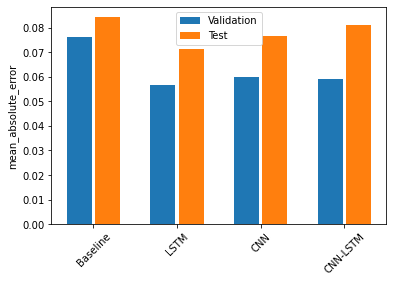

In [43]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = baseline.metrics_names.index('mean_absolute_error')
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

pyplot.ylabel('mean_absolute_error')
pyplot.bar(x - 0.17, val_mae, width, label='Validation')
pyplot.bar(x + 0.17, test_mae, width, label='Test')
pyplot.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
_ = pyplot.legend()